# Project. Contexto for popular words in Russian. Basic strategies


In [ ]:
import numpy as np
import pandas as pd
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from time import sleep
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
f = open("russian_nouns.txt")
lines = f.readlines()
f.close()
nouns = [line[:-1] for line in lines]
N = len(nouns)
N

51301

In [ ]:
np.random.seed(2807)
nouns = np.random.choice(nouns, 1000)
N = len(nouns)

In [ ]:
def simple_game(game_rank):
    target = np.random.randint(N)
    win_flag = False
    attempts = 0
    while True:
        print("Input the number")
        attempt = int(input())
        rank = int(game_rank[target][attempt])
        if attempt == -1:
            break
        print("The rank of your word is " + str(rank))
        attempts += 1
        if rank == 0:
            win_flag = True
            break
    print("Number of attempts is " + str(attempts))
    print("answer is " + str(target))

In [ ]:
# Auxiliary function. Determining the closest number to the number num that has not been used before

def get_nearest_num(num, used, num_set=np.arange(N)):
    if num not in used:
        return num
    min_diff = np.inf
    nearest = np.nan
    for i in num_set:
        if i not in used:
            diff = np.abs(num - i)
            if diff < min_diff:
                min_diff = diff
                nearest = i
    return nearest

In [ ]:
def player_rank_using(target, first_move, game_rank, player_rank):
    attempts = 1
    move = first_move
    used = []
    while target != move:
        attempts += 1
        game_output = int(game_rank[target][move])
        used.append(move)
        next_move = -1
        curr_used = []
        while next_move == -1:
            output = get_nearest_num(game_output, curr_used)
            for k in range(N):
                if player_rank[move][k] == output:
                    next_move = k
            if next_move in used:
                curr_used.append(output)
                next_move = -1
        move = next_move
    return attempts

In [ ]:
def maximum_likelihood_using(target, first_move, game_rank, player_rank):
    attempts = 1
    move = first_move
    used = np.array([False for _ in range(N)])
    sum_diff = np.zeros(N)
    while target != move:
        attempts += 1
        game_output = int(game_rank[target][move])
        used[move] = True
        for k in range(N):
            sum_diff[k] += np.abs(player_rank[k][move] - game_output)
        available_sumdiff = np.where(used, np.inf, sum_diff)
        move = np.argmin(available_sumdiff)
    return attempts

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

import torch
import torch.nn.functional as f

from transformers import BertModel, BertTokenizer

from time import sleep

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from abc import ABC
class Analyzer(ABC):
  def __init__(
      self,
      similarity_func,
      bert_version : str,
      device,
      ):
      self.similarity_func = similarity_func

      self.bert_version = bert_version
      self.tokenizer = BertTokenizer.from_pretrained(bert_version)
      self.model = BertModel.from_pretrained(bert_version)

      self.device=device

      self.model = self.model.eval()

  def get_word_emb(
      self,
      token : str
      ):
      encoding = self.tokenizer(
          token,
          padding=True,
          return_tensors='pt'
          ).to(self.device)

      for tokens in encoding['input_ids']:
        self.tokenizer.convert_ids_to_tokens(tokens)

      with torch.no_grad():
        embed = self.model(**encoding)[0]

      avg_embed = embed.mean(dim=1)

      return avg_embed

  def get_similarity(self, embed1, embed2):
      return self.similarity_func(embed1, embed2)[0]

In [ ]:
def experiment(sim, sim_player):
  game_rank = np.zeros((N, N))
  for i in tqdm(range(N)):
      game_rank[i] = np.argsort(np.argsort(sim[i])[::-1])

  player_rank = np.zeros((N, N))
  for i in tqdm(range(N)):
      player_rank[i] = np.argsort(np.argsort(sim_player[i])[::-1])

  rank_difference = np.zeros(N)
  for i in tqdm(range(N)):
      for j in range(N):
          r = game_rank[i][j]
          rank_difference[int(r)] += np.abs(game_rank[i][j] - player_rank[i][j])
  rank_difference /= N
  print(f"Average rank diffirence: {rank_difference.mean()}")

  plt.scatter(np.arange(N), rank_difference, s=1)
  plt.xlabel('rank by game')
  plt.ylabel('abs diff between player and game ranks')
  plt.show()

  print("-"*25)
  print("PRU")
  np.random.seed(42)
  M = 200
  PRU_num_moves_to_win = np.zeros(M)
  for k in tqdm(range(M)):
      i = np.random.choice(N)
      j = np.random.choice(N)
      PRU_num_moves_to_win[k] = player_rank_using(i, j, game_rank, player_rank)

  print(f"Average moves to win in PRU = {PRU_num_moves_to_win.mean()}")
  print(f"Standard deviation of moves to win in PRU = {PRU_num_moves_to_win.std()}")
  print(f"Median of moves to win in PRU = {np.median(PRU_num_moves_to_win)}")

  plt.hist(PRU_num_moves_to_win, bins=25)
  plt.xlabel('attempts for win')
  plt.show()

  print("-"*25)
  print("MLU")
  np.random.seed(42)
  M = 200
  MLU_num_moves_to_win = np.zeros(M)
  for k in tqdm(range(M)):
      i = np.random.choice(N)
      j = np.random.choice(N)
      MLU_num_moves_to_win[k] = maximum_likelihood_using(i, j, game_rank, player_rank)

  print(f"Average moves to win in MLU = {MLU_num_moves_to_win.mean()}")
  print(f"Standard deviation of moves to win in MLU = {MLU_num_moves_to_win.std()}")
  print(f"Median of moves to win in MLU = {np.median(MLU_num_moves_to_win)}")

  plt.hist(MLU_num_moves_to_win, bins=25)
  plt.xlabel('attempts for win')
  plt.show()

In [ ]:
def create_sim_setting(bert_version):
  embed_calc = Analyzer(
    similarity_func=torch.nn.CosineSimilarity(),
    bert_version=bert_version,
    device=device
  )

  N = len(nouns)
  emb_dict = dict()
  for noun in tqdm(nouns):
    emb_dict[noun] = embed_calc.get_word_emb(token=noun)

  sim = np.zeros((N, N))
  for i in tqdm(range(N)):
      for j in range(N):
          sim[i][j] = embed_calc.get_similarity(embed1=emb_dict[nouns[i]], embed2=emb_dict[nouns[j]])

  return sim

In [ ]:
sim = create_sim_setting(bert_version='DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:46<00:00, 21.58it/s]


In [ ]:
sim_player = create_sim_setting(bert_version='cointegrated/rubert-tiny2')

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:44<00:00, 22.69it/s]


In [ ]:
sim_pref_1 = create_sim_setting(bert_version='sberbank-ai/ruBert-base')

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:45<00:00, 22.16it/s]


In [ ]:
sim_pref_2 = create_sim_setting(bert_version='sismetanin/rubert-toxic-pikabu-2ch')

Some weights of the model checkpoint at sismetanin/rubert-toxic-pikabu-2ch were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:44<00:00, 22.26it/s]


In [ ]:
list_of_prefs = [
    (sim, 'DeepPavlov/rubert-base-cased'),
    (sim_player, 'cointegrated/rubert-tiny2'),
    (sim_pref_1, 'sberbank-ai/ruBert-base'),
    (sim_pref_2, 'sismetanin/rubert-toxic-pikabu-2ch')
    ]

game pref is DeepPavlov/rubert-base-cased
player pref is cointegrated/rubert-tiny2


100%|██████████| 1000/1000 [00:04<00:00, 247.70it/s]


Average rank diffirence: 245.63071000000002


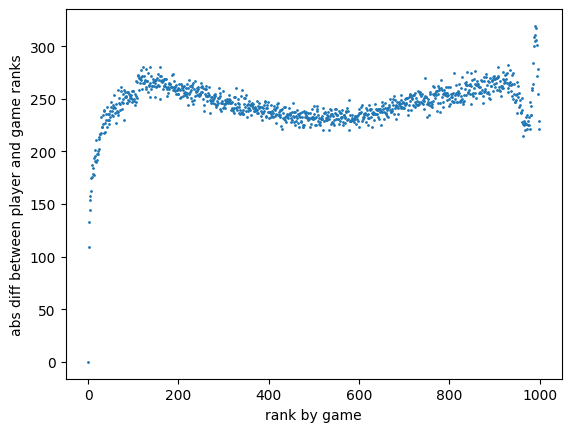

-------------------------
PRU


100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


Average moves to win in PRU = 413.175
Standard deviation of moves to win in PRU = 281.2083646960026
Median of moves to win in PRU = 331.5


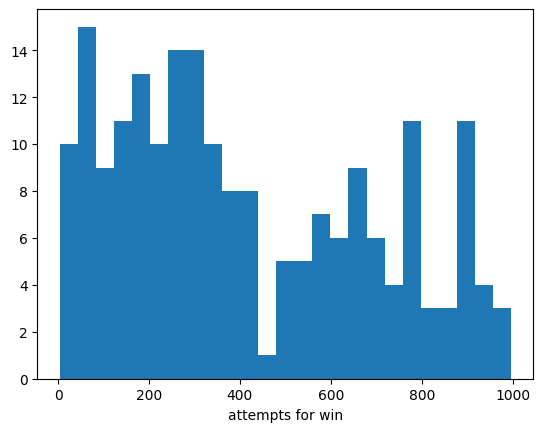

-------------------------
MLU


100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


Average moves to win in MLU = 153.04
Standard deviation of moves to win in MLU = 169.6139392856613
Median of moves to win in MLU = 79.0


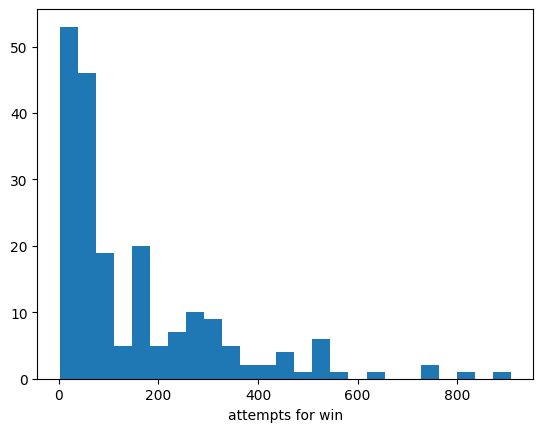

--------------------------------------------------
game pref is DeepPavlov/rubert-base-cased
player pref is sberbank-ai/ruBert-base


100%|██████████| 1000/1000 [00:02<00:00, 336.89it/s]


Average rank diffirence: 266.401582


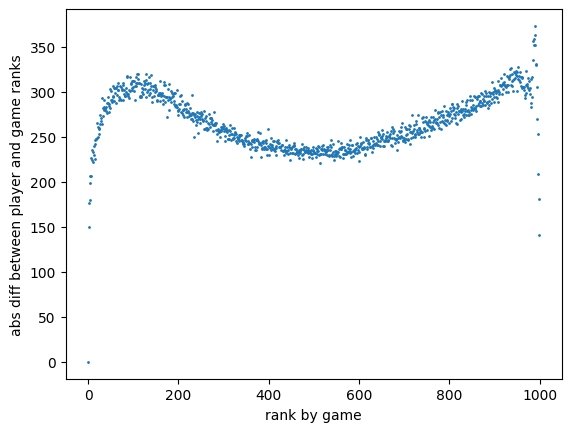

-------------------------
PRU


100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Average moves to win in PRU = 381.36
Standard deviation of moves to win in PRU = 274.70242154010947
Median of moves to win in PRU = 327.5


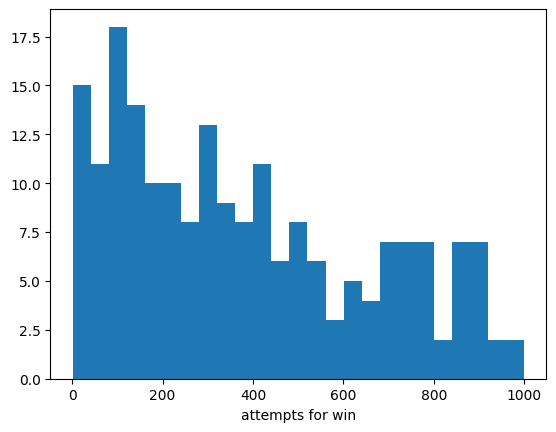

-------------------------
MLU


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Average moves to win in MLU = 197.035
Standard deviation of moves to win in MLU = 199.5856301816341
Median of moves to win in MLU = 96.5


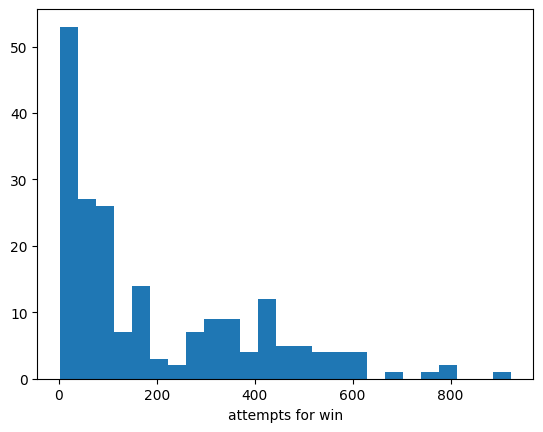

--------------------------------------------------
game pref is DeepPavlov/rubert-base-cased
player pref is sismetanin/rubert-toxic-pikabu-2ch


100%|██████████| 1000/1000 [00:03<00:00, 271.03it/s]


Average rank diffirence: 289.617814


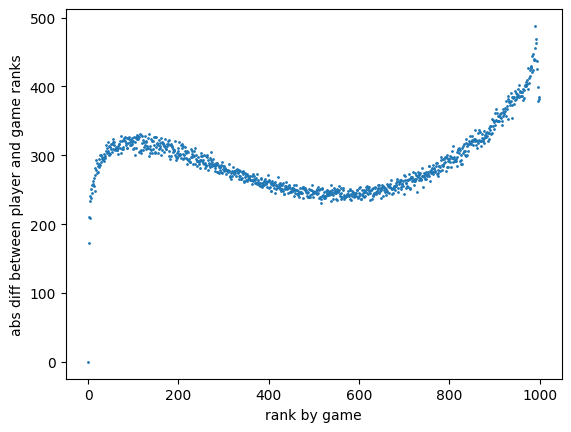

-------------------------
PRU


100%|██████████| 200/200 [03:28<00:00,  1.04s/it]


Average moves to win in PRU = 392.93
Standard deviation of moves to win in PRU = 268.19450982449285
Median of moves to win in PRU = 356.5


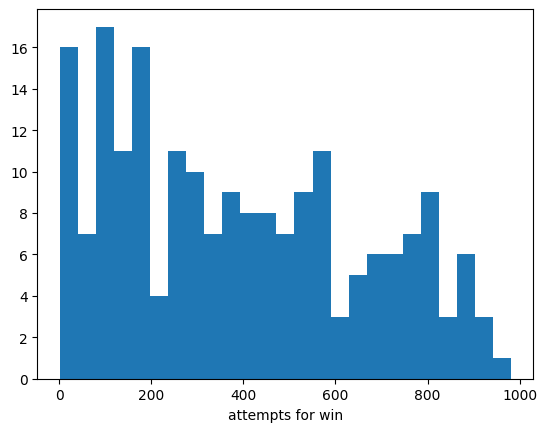

-------------------------
MLU


100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


Average moves to win in MLU = 215.93
Standard deviation of moves to win in MLU = 210.5948600987213
Median of moves to win in MLU = 105.5


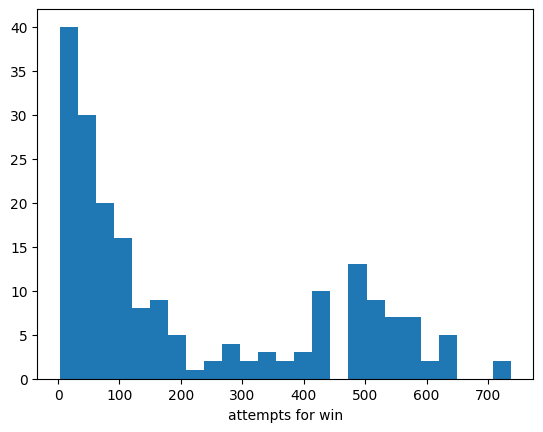

--------------------------------------------------
game pref is cointegrated/rubert-tiny2
player pref is sberbank-ai/ruBert-base


100%|██████████| 1000/1000 [00:04<00:00, 202.36it/s]


Average rank diffirence: 265.780272


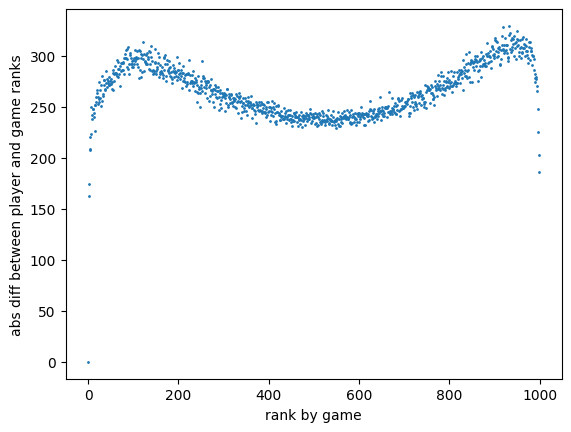

-------------------------
PRU


100%|██████████| 200/200 [02:53<00:00,  1.16it/s]


Average moves to win in PRU = 356.495
Standard deviation of moves to win in PRU = 266.10714003010145
Median of moves to win in PRU = 292.5


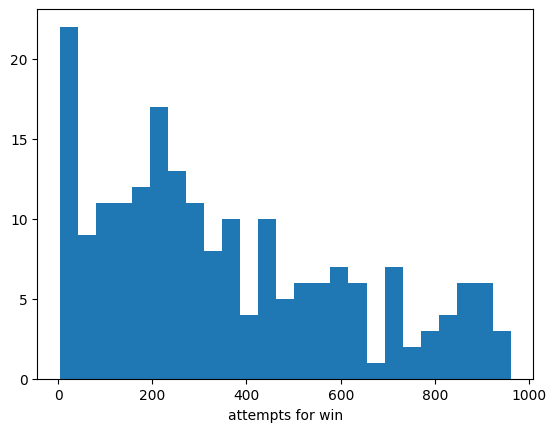

-------------------------
MLU


100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


Average moves to win in MLU = 142.995
Standard deviation of moves to win in MLU = 163.45071114865178
Median of moves to win in MLU = 74.5


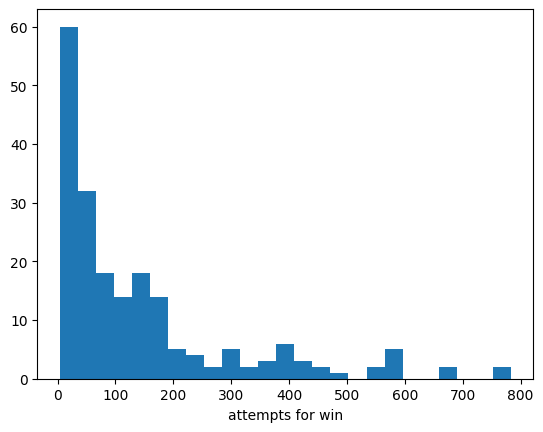

--------------------------------------------------
game pref is cointegrated/rubert-tiny2
player pref is sismetanin/rubert-toxic-pikabu-2ch


100%|██████████| 1000/1000 [00:03<00:00, 269.84it/s]


Average rank diffirence: 299.42927199999997


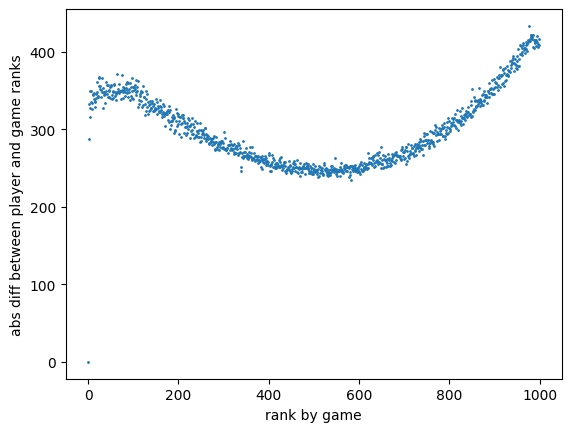

-------------------------
PRU


100%|██████████| 200/200 [07:04<00:00,  2.12s/it]


Average moves to win in PRU = 407.305
Standard deviation of moves to win in PRU = 280.1268140949738
Median of moves to win in PRU = 379.0


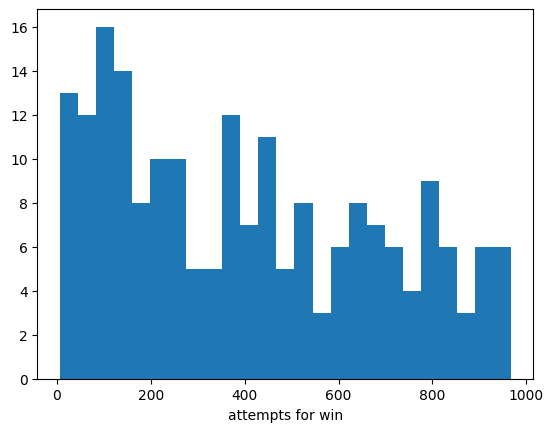

-------------------------
MLU


100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


Average moves to win in MLU = 261.16
Standard deviation of moves to win in MLU = 215.46265198405035
Median of moves to win in MLU = 172.0


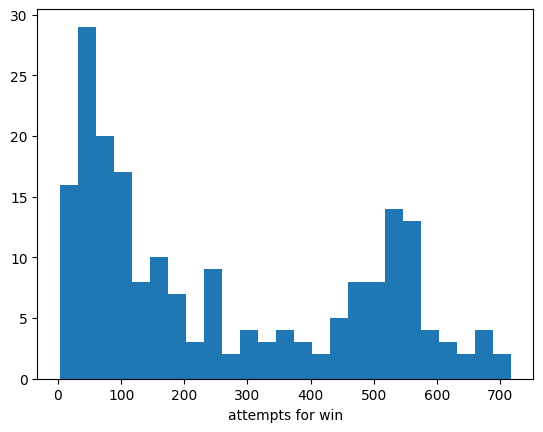

--------------------------------------------------
game pref is sberbank-ai/ruBert-base
player pref is sismetanin/rubert-toxic-pikabu-2ch


100%|██████████| 1000/1000 [00:04<00:00, 214.07it/s]


Average rank diffirence: 302.27554399999997


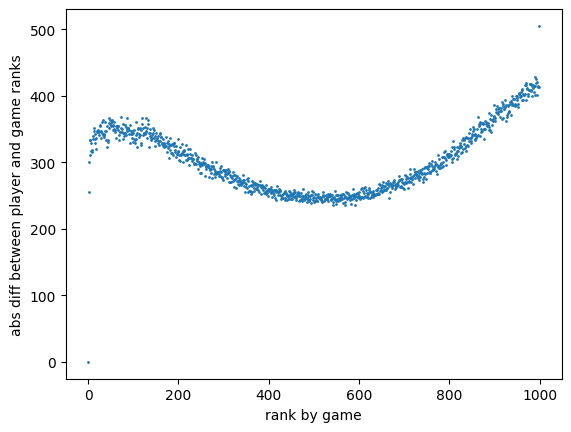

-------------------------
PRU


100%|██████████| 200/200 [16:30<00:00,  4.95s/it]


Average moves to win in PRU = 430.025
Standard deviation of moves to win in PRU = 280.46519280474
Median of moves to win in PRU = 408.0


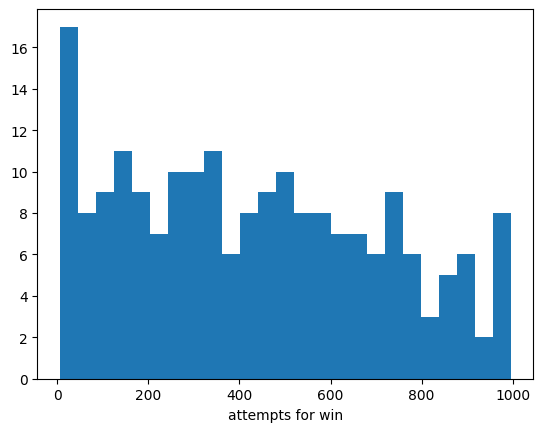

-------------------------
MLU


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Average moves to win in MLU = 241.05
Standard deviation of moves to win in MLU = 228.61506402684842
Median of moves to win in MLU = 137.0


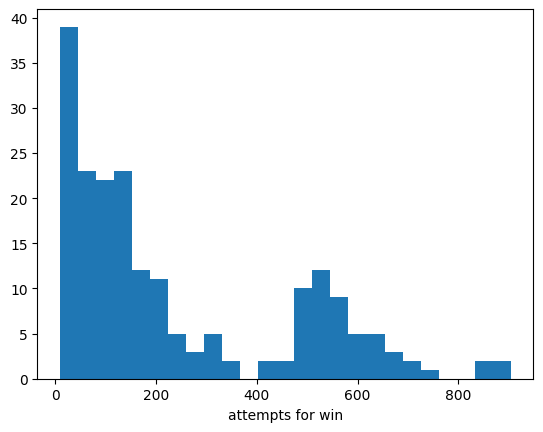

--------------------------------------------------


In [ ]:
for id, (pref, model_name) in enumerate(list_of_prefs):
  for player_pref, player_model_name in list_of_prefs[id+1:]:
    print(f'game pref is {model_name}')
    print(f'player pref is {player_model_name}')
    experiment(sim=pref, sim_player=player_pref)
    print('-'*50)